<center><img src="../images/DLI Header.png" alt="标题" style="width: 400px;"/></center>

# Jetson Nano 之 AI 使用入门
### 交互式分类工具

此 notebook 是 NVIDIA 深度学习学院 (DLI)“Jetson Nano 之 AI 使用入门”课程中提供的一种交互式数据采集、训练和测试工具。此工具专用于在 Jetson Nano 上运行，具体请参阅在线 DLI 课程页面中提供的详细说明。

如要使用此工具，首先需设置“**Camera**”（相机）和“**Task**”（任务）代码单元定义，然后执行所有单元。此 notebook 底部随即会显示交互式工具小组件。之后，您可使用该工具以迭代和交互方式收集、添加、训练和测试数据！

我们有意简化了此 notebook 的相关说明，以便您快速了解所需资讯。请查看 DLI 课程页面，了解有关工具操作和项目创建的详细信息。

### 摄像头
首先，创建相机并将其设置为 `running`。根据所使用的相机类型（USB 或 CSI），取消对相应相机选中行的注释。执行此单元可能需要几秒钟。

<div style="border:2px solid black; background-color:#e3ffb3; font-size:12px; padding:8px; margin-top: auto;">
<h4><i>提示</i></h4>
    <p>一次仅限使用一个 CSICamera 或 USBCamera 实例。在开始此 notebook 前，请确保您已在其他已运行的 notebook 中执行了“关闭”单元，从而使相机得以释放。
    </p>
</div>

In [1]:
# Check device number
!ls -ltrh /dev/video*

crw-rw---- 1 root video 81, 0 Feb 20 08:32 /dev/video0


In [2]:
from jetcam.usb_camera import USBCamera
from jetcam.csi_camera import CSICamera

# for USB Camera (Logitech C270 webcam), uncomment the following line
camera = USBCamera(width=224, height=224, capture_device=0) # confirm the capture_device number

# for CSI Camera (Raspberry Pi Camera Module V2), uncomment the following line
# camera = CSICamera(width=224, height=224, capture_device=0) # confirm the capture_device number

camera.running = True
print("camera created")

camera created


### 任务
接下来，定义项目 `TASK` 以及要收集的数据的 `CATEGORIES`。您还可使用所选名称为多个 `DATASETS` 定义空间。

取消注释或编辑所构建分类任务的关联行，然后执行此单元。
执行此单元仅需几秒钟。

In [3]:
import torchvision.transforms as transforms
from dataset import ImageClassificationDataset

# TASK = 'thumbs'
# TASK = 'emotions'
# TASK = 'fingers'
# TASK = 'diy'
TASK = 'fatigue_driving'

# CATEGORIES = ['thumbs_up', 'thumbs_down']
# CATEGORIES = ['none', 'happy', 'sad', 'angry']
# CATEGORIES = ['1', '2', '3', '4', '5']
# CATEGORIES = [ 'diy_1', 'diy_2', 'diy_3']
CATEGORIES = ['eye_open', 'eye_closed']

# DATASETS = ['A', 'B']
# DATASETS = ['A', 'B', 'C']
DATASETS = ['A']

TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

datasets = {}
for name in DATASETS:
    # datasets[name] = ImageClassificationDataset('../data/classification/' + TASK + '_' + name, CATEGORIES, TRANSFORMS)
    datasets[name] = ImageClassificationDataset('/nvdli-nano/data/fatigue_driving/' + TASK + '_' + name, CATEGORIES, TRANSFORMS)
    
print("{} task with {} categories defined".format(TASK, CATEGORIES))

fatigue_driving task with ['eye_open', 'eye_closed'] categories defined


In [4]:
# Set up the data directory location if not there already
# DATA_DIR = '/nvdli-nano/data/classification/'
DATA_DIR = '/nvdli-nano/data/fatigue_driving/'
!mkdir -p {DATA_DIR}

### 数据收集
执行下方单元，以创建数据采集工具小组件。执行此单元仅需几秒钟。

In [5]:
import ipywidgets
import traitlets
from IPython.display import display
from jetcam.utils import bgr8_to_jpeg

# initialize active dataset
dataset = datasets[DATASETS[0]]

# unobserve all callbacks from camera in case we are running this cell for second time
camera.unobserve_all()

# create image preview
camera_widget = ipywidgets.Image()
traitlets.dlink((camera, 'value'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# create widgets
dataset_widget = ipywidgets.Dropdown(options=DATASETS, description='dataset')
category_widget = ipywidgets.Dropdown(options=dataset.categories, description='category')
count_widget = ipywidgets.IntText(description='count')
save_widget = ipywidgets.Button(description='add')

# manually update counts at initialization
count_widget.value = dataset.get_count(category_widget.value)

# sets the active dataset
def set_dataset(change):
    global dataset
    dataset = datasets[change['new']]
    count_widget.value = dataset.get_count(category_widget.value)
dataset_widget.observe(set_dataset, names='value')

# update counts when we select a new category
def update_counts(change):
    count_widget.value = dataset.get_count(change['new'])
category_widget.observe(update_counts, names='value')

# save image for category and update counts
def save(c):
    dataset.save_entry(camera.value, category_widget.value)
    count_widget.value = dataset.get_count(category_widget.value)
save_widget.on_click(save)

data_collection_widget = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget]), dataset_widget, category_widget, count_widget, save_widget
])

# display(data_collection_widget)
print("data_collection_widget created")

data_collection_widget created


### 模型
执行下方单元，以定义神经网络，并调整全连接层 (`fc`) 以匹配项目所需的输出。执行此单元可能需要几秒钟。

In [6]:
import torch
import torchvision


device = torch.device('cuda')

# ALEXNET
# model = torchvision.models.alexnet(pretrained=True)
# model.classifier[-1] = torch.nn.Linear(4096, len(dataset.categories))

# SQUEEZENET 
# model = torchvision.models.squeezenet1_1(pretrained=True)
# model.classifier[1] = torch.nn.Conv2d(512, len(dataset.categories), kernel_size=1)
# model.num_classes = len(dataset.categories)

# RESNET 18
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, len(dataset.categories))

# RESNET 34
# model = torchvision.models.resnet34(pretrained=True)
# model.fc = torch.nn.Linear(512, len(dataset.categories))
    
model = model.to(device)

model_save_button = ipywidgets.Button(description='save model')
model_load_button = ipywidgets.Button(description='load model')
# model_path_widget = ipywidgets.Text(description='model path', value='/nvdli-nano/data/classification/my_model.pth')
model_path_widget = ipywidgets.Text(description='model path', value='/nvdli-nano/data/fatigue_driving/my_model.pth')

def load_model(c):
    model.load_state_dict(torch.load(model_path_widget.value))
model_load_button.on_click(load_model)
    
def save_model(c):
    torch.save(model.state_dict(), model_path_widget.value)
model_save_button.on_click(save_model)

model_widget = ipywidgets.VBox([
    model_path_widget,
    ipywidgets.HBox([model_load_button, model_save_button])
])

# display(model_widget)
print("model configured and model_widget created")

model configured and model_widget created


### 实时执行
执行下方单元，以设置实时执行小组件。执行此单元仅需几秒钟。

In [7]:
import threading
import time
from utils import preprocess
import torch.nn.functional as F

state_widget = ipywidgets.ToggleButtons(options=['stop', 'live'], description='state', value='stop')
prediction_widget = ipywidgets.Text(description='prediction')
score_widgets = []
for category in dataset.categories:
    score_widget = ipywidgets.FloatSlider(min=0.0, max=1.0, description=category, orientation='vertical')
    score_widgets.append(score_widget)

def live(state_widget, model, camera, prediction_widget, score_widget):
    global dataset
    while state_widget.value == 'live':
        image = camera.value
        preprocessed = preprocess(image)
        output = model(preprocessed)
        output = F.softmax(output, dim=1).detach().cpu().numpy().flatten()
        category_index = output.argmax()
        prediction_widget.value = dataset.categories[category_index]
        for i, score in enumerate(list(output)):
            score_widgets[i].value = score
            
def start_live(change):
    if change['new'] == 'live':
        execute_thread = threading.Thread(target=live, args=(state_widget, model, camera, prediction_widget, score_widget))
        execute_thread.start()

state_widget.observe(start_live, names='value')

live_execution_widget = ipywidgets.VBox([
    ipywidgets.HBox(score_widgets),
    prediction_widget,
    state_widget
])

# display(live_execution_widget)
print("live_execution_widget created")

live_execution_widget created


### 训练和评估
执行下方单元，以定义训练器及用于控制该训练器的小组件。执行此单元可能需要几秒钟。

In [8]:
BATCH_SIZE = 8

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

epochs_widget = ipywidgets.IntText(description='epochs', value=1)
eval_button = ipywidgets.Button(description='evaluate')
train_button = ipywidgets.Button(description='train')
loss_widget = ipywidgets.FloatText(description='loss')
accuracy_widget = ipywidgets.FloatText(description='accuracy')
progress_widget = ipywidgets.FloatProgress(min=0.0, max=1.0, description='progress')

def train_eval(is_training):
    global BATCH_SIZE, LEARNING_RATE, MOMENTUM, model, dataset, optimizer, eval_button, train_button, accuracy_widget, loss_widget, progress_widget, state_widget
    
    try:
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=True
        )

        state_widget.value = 'stop'
        train_button.disabled = True
        eval_button.disabled = True
        time.sleep(1)

        if is_training:
            model = model.train()
        else:
            model = model.eval()
        while epochs_widget.value > 0:
            i = 0
            sum_loss = 0.0
            error_count = 0.0
            for images, labels in iter(train_loader):
                # send data to device
                images = images.to(device)
                labels = labels.to(device)

                if is_training:
                    # zero gradients of parameters
                    optimizer.zero_grad()

                # execute model to get outputs
                outputs = model(images)

                # compute loss
                loss = F.cross_entropy(outputs, labels)

                if is_training:
                    # run backpropogation to accumulate gradients
                    loss.backward()

                    # step optimizer to adjust parameters
                    optimizer.step()

                # increment progress
                error_count += len(torch.nonzero(outputs.argmax(1) - labels).flatten())
                count = len(labels.flatten())
                i += count
                sum_loss += float(loss)
                progress_widget.value = i / len(dataset)
                loss_widget.value = sum_loss / i
                accuracy_widget.value = 1.0 - error_count / i
                
            if is_training:
                epochs_widget.value = epochs_widget.value - 1
            else:
                break
    except e:
        pass
    model = model.eval()

    train_button.disabled = False
    eval_button.disabled = False
    state_widget.value = 'live'
    
train_button.on_click(lambda c: train_eval(is_training=True))
eval_button.on_click(lambda c: train_eval(is_training=False))
    
train_eval_widget = ipywidgets.VBox([
    epochs_widget,
    progress_widget,
    loss_widget,
    accuracy_widget,
    ipywidgets.HBox([train_button, eval_button])
])

# display(train_eval_widget)
print("trainer configured and train_eval_widget created")

trainer configured and train_eval_widget created


### 显示交互式工具！

交互式工具包括数据采集、训练和测试小组件。

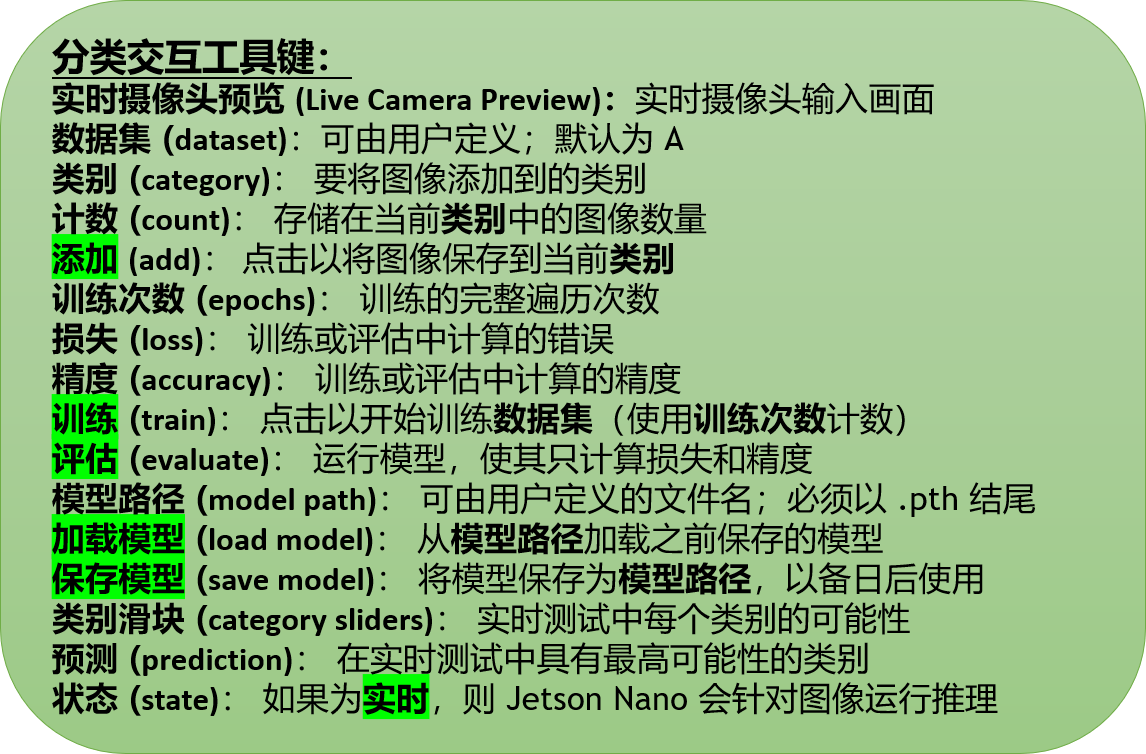<center><img src="../images/classification_tool_key2.png" alt="工具密钥" width=500/></center>
<br>
<center><img src="../images/classification_tool_key1.png" alt="工具密钥"/></center>

执行下方单元，以创建并显示完整的交互式小组件。按照在线 DLI 课程页面中的说明构建项目。

In [9]:
# Combine all the widgets into one display
all_widget = ipywidgets.VBox([
    ipywidgets.HBox([data_collection_widget, live_execution_widget]), 
    train_eval_widget,
    model_widget
])

display(all_widget)

<h1 style="background-color:#76b900;"></h1>

## 请先不要离开...<br><br>关闭相机和 notebook 内核以释放相机资源

In [ ]:
# Attention!  Execute this cell before moving to another notebook
# The USB camera application only requires that the notebook be reset
# The CSI camera application requires that the 'camera' object be specifically released

import os
import IPython

if type(camera) is CSICamera:
    print("Ignore 'Exception in thread' tracebacks\n")
    camera.cap.release()

os._exit(00)

返回 DLI 课程页面查看后续说明。

<center><img src="../images/DLI Header.png" alt="标题" style="width: 400px;"/></center>